In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator

from scipy.linalg import eigh_tridiagonal
from copy import deepcopy
from scipy.optimize import curve_fit

#this is the way to import qutip
from qutip import *
from numba import njit
import time

# Hamiltonian for Heisenberg 3D model.
\begin{equation}\label{eq:H}
    \mathcal{\hat{H}} = h \sum_{i=1}^N \sigma_z^i + \sum_{i=1}^{N-1} \sigma_x^{i+1} \sigma_x^i + \sum_{i=1}^{N-1} \sigma_y^{i+1} \sigma_y^i + \sum_{i=1}^{N-1} \sigma_z^{i+1} \sigma_z^i
\end{equation}

### Initialize stuff

In [2]:
###DEBUGGING STUFF
DEBUG_FLAG         = False
EXIT_ON_ERROR_FLAG = True
PRINT_OUTPUT       = True

In [3]:
def assertion(first, relate, second, PRINT_OUTPUT = False):
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    result = ops[relate](first, second)
    if PRINT_OUTPUT:
        print(first, relate, second, " ===> ", result)
    return result

def debug_checkpoint(first, relate, second, message, exit_flag = False, print_flag = False):
    #if exit flag is set to true, then exit the program and print message
    if (exit_flag):
        assert assertion(first, relate, second, print_flag), message
    #if set to false, then catch the exception and print the message that a test has failed
    else:
        try:
            assert assertion(first, relate, second, print_flag)
        except AssertionError as e:
            print(message)
            
def initial_debug(DEBUG_FLAG,dim, nn):
    if (DEBUG_FLAG):
        debug_checkpoint(type(nn), "=", int,
                         "Number of particles must be integer", EXIT_ON_ERROR_FLAG, PRINT_OUTPUT)
        debug_checkpoint(nn, ">", 0,
                         "Number of particles must be positive", EXIT_ON_ERROR_FLAG, PRINT_OUTPUT)
        debug_checkpoint(type(dim), "=", int,
                         "Number of dimensions must be integer", EXIT_ON_ERROR_FLAG, PRINT_OUTPUT)
        debug_checkpoint(dim, ">", 0, 
                         "Number of dimensions must be positive", EXIT_ON_ERROR_FLAG, PRINT_OUTPUT)
        
def matrix_debug(DEBUG_FLAG, Ham_obj,dim,nn):
    if (DEBUG_FLAG):
        debug_checkpoint(Ham_obj.shape[0], "=", Ham_obj.shape[1],
                         "Hamiltonian must be square", EXIT_ON_ERROR_FLAG, PRINT_OUTPUT)
        debug_checkpoint(Ham_obj.shape[0], "=", dim**nn,
                         "Hamiltonian has incorrect dimensions", EXIT_ON_ERROR_FLAG, PRINT_OUTPUT)
        debug_checkpoint(Ham_obj.isherm, "=", True,
                         "Hamiltonian must be Hermitian", EXIT_ON_ERROR_FLAG, PRINT_OUTPUT)


## Beginning of the assignment

In [4]:
#number of particles
nn = 3
#dimensionality of Hilbert space
dim = 2

#set strength of transverse field
h_field = 1.

# create an empty matrix with type format Qobj of Qtip library
def create_emptyH_Qobj(dim, nn):
    '''
    This function creates an empty Qobj, given the dimension "dim" of the Hilbert space each spin belongs to
    and the number of spins "nn" considered.
    
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn with all elements set to zero 
    '''
    #create lists to make dimensions be the same
    dim_list = []
    for i in np.arange(nn):
        dim_list.append(dim)

    #initialize an empty Hamiltonian coherent with input data
    Hamiltonian_mat = np.zeros((dim**nn, dim**nn))
    Ham_obj = Qobj(Hamiltonian_mat, dims = [dim_list, dim_list])
    
    matrix_debug(DEBUG_FLAG,Ham_obj,dim,nn)

    return Ham_obj

#### Free parameters

In [5]:
dim = 2
nn = 10
h_field = 1.

# Functions for plain Hamiltonian, NO PBC

### $\sigma_x$,$\sigma_y$,$\sigma_z$ interaction terms

In [6]:
###################################
#                                 #
#            NO PBC               #
#                                 #
###################################


#sigma_x interactions
def Hx_int(dim, nn, int_strength = 1.):
    '''
    This function returns a Qobj that describes the interaction term along x-axis of the 1d Heisenberg model spin-chain,
    given the strength of interaction, the number "nn" of spin and the dimension of the Hilbert space for every particles.
    here, we do not consider periodic boundary conditions.
    
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    int_strength: strength of the interaction term "J_x"
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaction term along x-axis for the Heisenberg 1-d model and no boundary conditions
    '''
    hx_int = create_emptyH_Qobj(dim, nn)
    #compute sigma y interaction
    for index_ii in range(0, nn - 1):
        #create an operator for a single particle in 2-dim 
        #(needs to be instantiated after the delete command)
        temp_obj = create_emptyH_Qobj(dim, 1)
        if index_ii == 0:
            temp_obj = sigmax()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1, nn):
            if ((index_ii == index_jj)|(index_jj == (index_ii+1))):
                temp_obj = tensor(temp_obj, sigmax()/2)
            else:
                temp_obj = tensor(temp_obj, qeye(dim))
        hx_int += int_strength*Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj

    matrix_debug(DEBUG_FLAG,hx_int,dim,nn)

    return hx_int

#sigma_y interactions
def Hy_int(dim, nn, int_strength = 1.):
    '''
    This function returns a Qobj that describes the interaction term along y-axis of the 1d Heisenberg model spin-chain,
    given the strength of interaction, the number "nn" of spin and the dimension of the Hilbert space for every particles.
    here, we do not consider periodic boundary conditions.
    
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    int_strength: strength of the interaction term "J_y"
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaction term along y-axis for the Heisenberg 1-d model and no boundary conditions
    '''
    hy_int = create_emptyH_Qobj(dim, nn)
    #compute sigma y interaction
    for index_ii in range(0, nn - 1):
        #create an operator for a single particle in 2-dim 
        #(needs to be instantiated after the delete command)
        temp_obj = create_emptyH_Qobj(dim, 1)
        if index_ii == 0:
            temp_obj = sigmay()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1, nn):
            if ((index_ii == index_jj)|(index_jj == (index_ii+1))):
                temp_obj = tensor(temp_obj, sigmay()/2)
            else:
                temp_obj = tensor(temp_obj, qeye(dim))
        hy_int += int_strength*Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj

    matrix_debug(DEBUG_FLAG,hy_int,dim,nn)

    return hy_int

#sigma_z interactions
def Hz_int(dim, nn, int_strength = 1.):
    '''
    This function returns a Qobj that describes the interaction term along z-axis of the 1d Heisenberg model spin-chain,
    given the strength of interaction, the number "nn" of spin and the dimension of the Hilbert space for every particles.
    here, we do not consider periodic boundary conditions.
    
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    int_strength: strength of the interaction term "J_z"
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaction term along z-axis for the Heisenberg 1-d model and no boundary conditions
    '''
    hz_int = create_emptyH_Qobj(dim, nn)
    #compute sigma z interaction
    for index_ii in range(0, nn - 1):
        #create an operator for a single particle in 2-dim 
        #(needs to be instantiated after the delete command)
        temp_obj = create_emptyH_Qobj(dim, 1)
        if index_ii == 0:
            temp_obj = sigmaz()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1, nn):
            if ((index_ii == index_jj)|(index_jj == (index_ii+1))):
                temp_obj = tensor(temp_obj, sigmaz()/2)
            else:
                temp_obj = tensor(temp_obj, qeye(dim))
        hz_int += int_strength*Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj

    matrix_debug(DEBUG_FLAG,hz_int,dim,nn)

    return hz_int

### Transverse field term

In [7]:
#compute external field interaction
def H_ext(dim, nn, h_field):
    '''
    This function returns a Qobj that describes the contribution to the energy of the system of an external magnetic field,
    aligned parallely to z-axis, given the dimension "dim", the number of spins "nn" and the amplitude of this field.
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    h_field: strength of the interaction term "J_z"
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaciton term of the spins with an external field, 
             parallel wrt z-axis
    '''
    h_ext = create_emptyH_Qobj(dim, nn)
    for index_ii in range(0,nn):
        #temp for the first iteration is the identity matrix unless we are considering the 1st particle
        if (index_ii == 0):
            temp_obj = sigmaz()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1,nn):
            if (index_jj == index_ii):
                temp_obj = tensor(temp_obj,sigmaz()/2)
            else:
                temp_obj = tensor(temp_obj,qeye(dim))
        h_ext += Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj
    matrix_debug(DEBUG_FLAG,h_ext,dim,nn)

    return h_ext*h_field

### Full Hamiltonain (NO PBC)

In [8]:
def Heisenberg_hamiltonian(dim, nn, h_field, int_strength = 1.):
    '''
    This function returns the full Hamiltonian of the Heisenberg 1-d spin chain model, given the dimension of the Hilbert
    space for every spin, the total number of spin, and the external field with NO boundary conditions.
    
    ###input###
    dim : dimension of the Hilbert space
    nn : number of spins
    h_field: magnitude of the external field, parallel to z-axis
    int_strength: interactions strength of between nearest neighbors spins. 
    
    ###output###
    H_total : Qobj, Hamiltonian of the system 
    
    '''
    
    initial_debug(DEBUG_FLAG,dim, nn)
    H_total  = H_ext(dim, nn, h_field)+ Hx_int(dim, nn, int_strength)+ Hy_int(dim, nn, int_strength)+ Hz_int(dim, nn, int_strength)
    matrix_debug(DEBUG_FLAG,H_total,dim, nn)
    
    return H_total

In [9]:
H_no_pbc = Heisenberg_hamiltonian(dim, nn, h_field)

H_no_pbc.eigenenergies()/nn

array([-0.495123  , -0.49306736, -0.46134952, ...,  0.62010565,
        0.625     ,  0.725     ])

# Functions for Hamiltonian (with PBC)

In [10]:
###################################
#                                 #
#          WITH PBC               #
#                                 #
###################################


#sigma_x interaction with PBC
def Hx_int_pbc(dim, nn, int_strength = 1.):
    '''
    This function returns a Qobj that describes the interaction term along x-axis of the 1d Heisenberg model spin-chain,
    given the strength of interaction, the number "nn" of spin and the dimension of the Hilbert space for every particles.
    here, we DO consider PERIODIC BOUNDARY CONDITIONS.
    
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    int_strength: strength of the interaction term "J_x" between nearest neighbors
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaction term along x-axis for 
             the Heisenberg 1-d model and periodic boundary conditions
    '''
    hx_int = create_emptyH_Qobj(dim, nn)
    
    #compute sigma x interaction
    for index_ii in range(0, nn ):
        #create an operator for a single particle in 2-dim 
        #(needs to be instantiated after the delete command)
        temp_obj = create_emptyH_Qobj(dim, 1)
        if index_ii == 0:
            temp_obj = sigmax()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1, nn):
            if ((index_ii == index_jj)|(index_jj == (index_ii+1))):
                temp_obj = tensor(temp_obj, sigmax()/2)
            else:
                temp_obj = tensor(temp_obj, qeye(dim))

        if index_ii==nn-1:
            temp_last_term = sigmax()/2
            for kk in range(1,nn-1):
                temp_last_term = tensor(temp_last_term,qeye(2))
            hx_int += int_strength*tensor(temp_last_term,sigmax()/2)
            del temp_last_term
        else:  
            hx_int += int_strength*Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj

    matrix_debug(DEBUG_FLAG,hx_int,dim,nn)

    return hx_int


#sigma_y interaction with PBC
def Hy_int_pbc(dim, nn, int_strength = 1.):
    '''
    This function returns a Qobj that describes the interaction term along y-axis of the 1d Heisenberg model spin-chain,
    given the strength of interaction, the number "nn" of spin and the dimension of the Hilbert space for every particles.
    here, we DO consider PERIODIC BOUNDARY CONDITIONS.
    
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    int_strength: strength of the interaction term "J_y" between nearest neighbors
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaction term along y-axis for 
             the Heisenberg 1-d model and periodic boundary conditions
    '''
    hy_int = create_emptyH_Qobj(dim, nn)
    
    #compute sigma y interaction
    for index_ii in range(0, nn ):
        #create an operator for a single particle in 2-dim 
        #(needs to be instantiated after the delete command)
        temp_obj = create_emptyH_Qobj(dim, 1)
        if index_ii == 0:
            temp_obj = sigmay()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1, nn):
            if ((index_ii == index_jj)|(index_jj == (index_ii+1))):
                temp_obj = tensor(temp_obj, sigmay()/2)
            else:
                temp_obj = tensor(temp_obj, qeye(dim))

        if index_ii==nn-1:
            temp_last_term = sigmay()/2
            for kk in range(1,nn-1):
                temp_last_term = tensor(temp_last_term,qeye(2))
            hy_int += int_strength*tensor(temp_last_term,sigmay()/2)
            del temp_last_term
        else:  
            hy_int += int_strength*Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj

    matrix_debug(DEBUG_FLAG,hy_int,dim,nn)

    return hy_int

#sigma_z interaction with PBC
def Hz_int_pbc(dim, nn, int_strength = 1.):
    '''
    This function returns a Qobj that describes the interaction term along z-axis of the 1d Heisenberg model spin-chain,
    given the strength of interaction, the number "nn" of spin and the dimension of the Hilbert space for every particles.
    here, we DO consider PERIODIC BOUNDARY CONDITIONS.
    
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    int_strength: strength of the interaction term "J_z" between nearest neighbors
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaction term along z-axis for 
             the Heisenberg 1-d model and periodic boundary conditions
    '''
    hz_int = create_emptyH_Qobj(dim, nn)
    #compute sigma z interaction
    for index_ii in range(0, nn):
        #create an operator for a single particle in 2-dim 
        #(needs to be instantiated after the delete command)
        temp_obj = create_emptyH_Qobj(dim, 1)
        if index_ii == 0:
            temp_obj = sigmaz()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1, nn):
            if ((index_ii == index_jj)|(index_jj == (index_ii+1))):
                temp_obj = tensor(temp_obj, sigmaz()/2)
            else:
                temp_obj = tensor(temp_obj, qeye(dim))
                
        if index_ii==nn-1:
            temp_last_term = sigmaz()/2
            for kk in range(1,nn-1):
                temp_last_term = tensor(temp_last_term,qeye(2))
            hz_int += int_strength*tensor(temp_last_term,sigmaz()/2)
            del temp_last_term
        else:  
            hz_int += int_strength*Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj

    matrix_debug(DEBUG_FLAG,hz_int,dim,nn)

    return hz_int


### External field term

In [11]:
#compute external field interaction
def H_ext(dim, nn, h_field):
    '''
    This function returns a Qobj that describes the contribution to the energy of the system of an external magnetic field,
    aligned parallely to z-axis, given the dimension "dim", the number of spins "nn" and the amplitude of this field.
    ###input###
    dim: dimension of Hilbert space each for every spin
    nn: number of spins considered
    h_field: strength of the interaction term "J_z"
    
    ###output###
    Ham_obj: a Qutip object of dimensions dim**nn for the interaciton term of the spins with an external field, 
             parallel wrt z-axis
    '''
    h_ext = create_emptyH_Qobj(dim, nn)
    for index_ii in range(0,nn):
        #temp for the first iteration is the identity matrix unless we are considering the 1st particle
        if (index_ii == 0):
            temp_obj = sigmaz()/2
        else:
            temp_obj = qeye(dim)
        for index_jj in range(1,nn):
            if (index_jj == index_ii):
                temp_obj = tensor(temp_obj,sigmaz()/2)
            else:
                temp_obj = tensor(temp_obj,qeye(dim))
        h_ext += Qobj(temp_obj)
        #free RAM and delete temp_object, later it'll be recreated
        del temp_obj
    matrix_debug(DEBUG_FLAG,h_ext,dim,nn)

    return h_ext*h_field

### Compute the Hamiltonian

In [12]:
# with PBC
def Heisenberg_hamiltonian_pbc(dim, nn, h_field, int_strength = 1.):
    '''
    This function returns the full Hamiltonian of the Heisenberg 1-d spin chain model, given the dimension of the Hilbert
    space for every spin, the total number of spin, and the external field with PERIODIC boundary conditions.
    
    ###input###
    dim : dimension of the Hilbert space
    nn : number of spins
    h_field: magnitude of the external field, parallel to z-axis
    int_strength: interactions strength of between nearest neighbors spins. 
    
    ###output###
    H_total : Qobj, Hamiltonian of the system with PERIODIC boundary conditions
    
    '''
    initial_debug(DEBUG_FLAG,dim, nn)
    H_total  = H_ext(dim, nn, h_field)+ Hx_int_pbc(dim, nn, int_strength)+ Hy_int_pbc(dim, nn, int_strength)+ Hz_int_pbc(dim, nn, int_strength)
    matrix_debug(DEBUG_FLAG,H_total,dim, nn)
    
    return H_total

### Example: Compute ground state for 3 particles
Used as benchmark for our Lanczos implementation, later

In [13]:
#Energies per particle
nn = 3
H_pbc = Heisenberg_hamiltonian_pbc(dim, nn, h_field)    
H_pbc.eigenenergies()/nn

array([-0.41666667, -0.41666667, -0.25      , -0.08333333, -0.08333333,
        0.08333333,  0.41666667,  0.75      ])

# Lanczos algorithm

In [14]:
#use just in time compiler to perform some operations in C-fashion style 
#and make the code go faster (almost machine code velocity)
@njit
def _axpy(x,y,a):
    for i in range(x.size):
        y[i] += a*x[i]

def lanczos_full(A,v0,m,out=None,eps=None):
    """
    out : numpy.ndarray, optional
        Array to store the Lanczos vectors in (e.g. `Q`). in memory efficient way.
    eps : float, optional
        Used to cutoff lanczos iteration when off diagonal matrix elements of `T` drops below this value. 

    This function performs a Lanczos algorithm to compute the largest in module eigenvalues of matrix A,
    given as input the "A" matrix of size "n x n", a random starting vector v0,
    the number of the Lanczos vectors "m" (which is in turn the size of the Krylov subspace), with the condition m < n.   
    ###input###
    A : n x n matrix it is requested to compute eigenvalues from
    v0: initial vector to start the Lanczos algorithm from, must be of length n
    m : Number of Lanczos vectors
    
    ###output###
    E : array of m eigenvalues of the Krylov subspace 
    
    """

    v0 = np.asanyarray(v0)
    n = v0.size
    dtype = np.result_type(A.dtype,v0.dtype)
    
    #check for input values
    if v0.ndim != 1:
        raise ValueError("expecting array with ndim=1 for initial Lanczos vector.")
    if m > n:
        raise ValueError("Requested size of Lanczos basis must be smaller then size of original space (e.g. m < n).")
        
    Q = np.zeros((m,n),dtype=dtype)
    Q[0,:] = v0[:]
    v = np.zeros_like(v0,dtype=dtype)
    r = np.zeros_like(v0,dtype=dtype)

    b = np.zeros((m,),dtype=v.real.dtype)
    a = np.zeros((m,),dtype=v.real.dtype)


    #introduce the eps to cutoff lanczos iteration when off diagonal matrix elements of `T` drops below this value. 
    eps = np.finfo(dtype).eps
    #compute the norm of v_0
    q_norm = np.linalg.norm(Q[0,:])
    
    #normalize v_0 (i.e. the first column of matrix Q, used to store elements)
    if np.abs(q_norm-1.0) > eps:
        np.divide(Q[0,:],q_norm,out=Q[0,:])
    
    A.dot(Q[0,:],out=r)
    
    a[0] = np.vdot(Q[0,:],r).real
    _axpy(Q[0,:],r,-a[0])
    
    b[0] = np.linalg.norm(r)
    
    #iterate the real algorithm
    i = 0
    for i in range(1,m,1):
        v[:] = Q[i-1,:]
        np.divide(r,b[i-1],out=Q[i,:])

        A.dot(Q[i,:],out=r)

        _axpy(v,r,-b[i-1])
        a[i] = np.vdot(Q[i,:],r).real
        
        _axpy(Q[i,:],r,-a[i])
        b[i] = np.linalg.norm(r)
        
        #when norm of off diagonal matrix elements is small,
        #break the iteration
        if b[i] < eps:
            m = i
            break

    #finally return eigenvalues of the tridiagonal matrix
    E = eigh_tridiagonal(a[:m],b[:m-1],eigvals_only=True)

    return E


# Hamiltonian with Periodic Boundary Conditions

### CPU time for H creation

In [15]:
# cpu time taken to obtain Hamiltonian with respect to nn
# this gives us an idea of how many particles to choose and what's is the limit of the computer
#note as large matrices are stored as "sparse", so the "real" upperbound nn is the one found when
#dealing with the "full" numpy array (indeed sparse matrices take less memory)
dim     = 2
h_field = 1.
H_time  = []
part_max = 15
for nn in range(2,part_max):
    time_elapsed_lst = []
    for i in range(25):
        start_time = time.time()
        H = Heisenberg_hamiltonian_pbc(2, nn, 1)
        end_time = time.time()
        time_elapsed_lst.append(end_time-start_time)
        
    print("N = %d, Time: %.5f s"%(nn, np.mean(time_elapsed_lst)))
    H_time.append(np.mean(time_elapsed_lst))

N = 2, Time: 0.00744 s
N = 3, Time: 0.01120 s
N = 4, Time: 0.01588 s
N = 5, Time: 0.02109 s
N = 6, Time: 0.02817 s
N = 7, Time: 0.03524 s
N = 8, Time: 0.04530 s
N = 9, Time: 0.05870 s
N = 10, Time: 0.09102 s
N = 11, Time: 0.19292 s
N = 12, Time: 0.60576 s
N = 13, Time: 2.19828 s
N = 14, Time: 7.29065 s


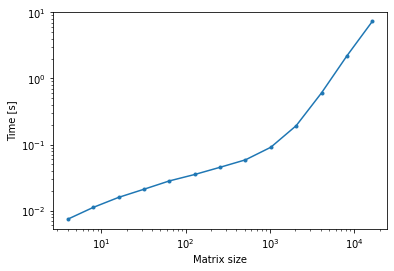

In [16]:
# Does it follow power law?
matrix_size = [2**i for i in range(2,part_max)]

# seems to follow power law
plt.plot(matrix_size, H_time, '.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Matrix size')
plt.ylabel('Time [s]')
plt.show()

Save results to file

In [17]:
df_creation_times = pd.DataFrame({'number_sites': range(2,part_max), 'matrix_size': matrix_size, 'creation_time': H_time})
df_creation_times.to_csv('Creation_times.csv', index = False)
df_creation_times

,number_sites,matrix_size,creation_time
0,2,4,0.007442
1,3,8,0.011201
2,4,16,0.015877
3,5,32,0.021085
4,6,64,0.028169
5,7,128,0.035242
6,8,256,0.045298
7,9,512,0.058695
8,10,1024,0.091023
9,11,2048,0.192920


In [98]:
df_creation_times = pd.read_csv('Creation_times.csv')
df_creation_times

,number_sites,matrix_size,creation_time
0,2,4,0.007442
1,3,8,0.011201
2,4,16,0.015877
3,5,32,0.021085
4,6,64,0.028169
5,7,128,0.035242
6,8,256,0.045298
7,9,512,0.058695
8,10,1024,0.091023
9,11,2048,0.192920


### What is the time complexity of builiding the Hamiltonian?

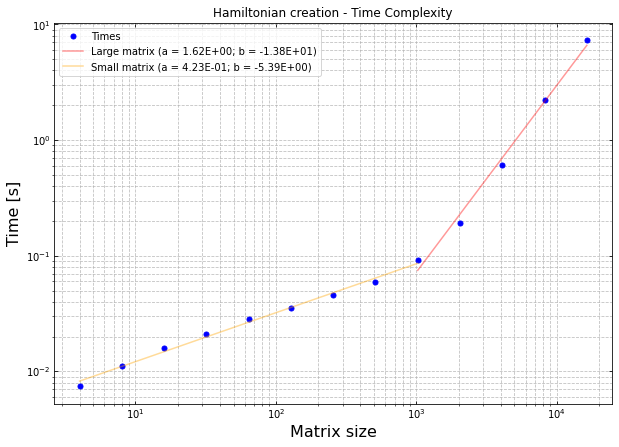

In [103]:
def func_square(x, a, b):
    return a*x**2
def func_power(x, n):
    return x**n 
def func(x, a, b):
    return a*np.exp(x/b)
def linear(x, a ,b):
    return a*x + b

####linear fit can be done ###
time_restricted_up = df_creation_times[df_creation_times.matrix_size > 1000]
time_restricted_down = df_creation_times[(df_creation_times.matrix_size < 1050)&(df_creation_times.matrix_size >= 4)]

log_x_up   = np.log(time_restricted_up.matrix_size)
log_x_down = np.log(time_restricted_down.matrix_size)

log_times_up   = np.log(time_restricted_up.creation_time)
log_times_down = np.log(time_restricted_down.creation_time)

popt_up, _   = curve_fit(linear, log_x_up , log_times_up)
popt_down, _ = curve_fit(linear, log_x_down , log_times_down)

predict_up   = [ np.exp(popt_up[0]*np.log(size) + popt_up[1]) for size in time_restricted_up.matrix_size]
predict_down = [ np.exp(popt_down[0]*np.log(size) + popt_down[1]) for size in time_restricted_down.matrix_size]

plt.figure(figsize=(10, 7))
plt.title('Hamiltonian creation - Time Complexity')

plt.plot(df_creation_times.matrix_size, df_creation_times.creation_time,".", markersize=10,  label = 'Times', color = 'blue')
plt.plot(time_restricted_up.matrix_size, predict_up, color = 'red', alpha = 0.4,  label = 'Large matrix (a = '+"{:.2E}".format(popt_up[0])+'; b = '+ "{:.2E}".format(popt_up[1])+')')
plt.plot(time_restricted_down.matrix_size, predict_down, color = 'orange', alpha = 0.4, label = 'Small matrix (a = '+"{:.2E}".format(popt_down[0])+'; b = '+ "{:.2E}".format(popt_down[1])+')')
plt.ylabel('Time [s]',size=16)
plt.xlabel('Matrix size',size=16)
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('Hamiltonian construction time - Qutip library')
plt.show()

## Proof that our Lanczos implementation works properly

In [19]:
#Parameters setting
nn  = 3
dim = 2
h_field = 1.

In [20]:
# ---- approximate solution by Lanczos
# v0 has to be given as input, and it belongs to subspace (Complex^n)
v0   = np.random.rand( dim**nn ) + np.random.rand( dim**nn )*1j 
v0  /= np.sqrt( np.dot( v0, v0 ) )

In [21]:
#m is number of iterations inside Lanczos, it must hold that m < n
Hamiltonian  = Heisenberg_hamiltonian_pbc(dim, nn, h_field)
EE = Hamiltonian.eigenenergies()
ee = EE/nn
ee

array([-0.41666667, -0.41666667, -0.25      , -0.08333333, -0.08333333,
        0.08333333,  0.41666667,  0.75      ])

In [22]:
#convert the QuObj to array
H_arr  = np.array(Hamiltonian)   
m = v0.shape[0] # value 7 in case of nn=3 
EN_L = lanczos_full(H_arr,v0,m)
en_l = EN_L/nn
en_l

array([-0.41666667, -0.4156285 , -0.25      , -0.08333333,  0.08333333,
        0.41666667,  0.74998341,  0.75      ])

In [23]:
#solving eigenvalues problem
# ---- full solve for eigenvalues for reference
EN_A, vsA = np.linalg.eig( Hamiltonian )
en_a = np.sort(EN_A)/nn
en_a.real

array([-0.41666667, -0.41666667, -0.25      , -0.08333333, -0.08333333,
        0.08333333,  0.41666667,  0.75      ])

# Computational time comparison for diagonalization using:
- numpy lin alg method 
- Lanczos method
- Qutip library

In [23]:
def get_lanczos_iteration_time(matrix, nn, v0, m, get_energies_flag = False, verbose = False):
    '''
    This function computes the Lanczos algorithm for an arbitrary number of times,
    on a matrix passed as input, and by using an initial vector v0. 
    The number of times that the algorithm is performed depends on the actual number of spins, to store times
    It returns the mean of the vector containing the times elapsed during all iterations, and 
    if "get_energies_flag" is True the array containing the energies
    '''
    if nn <= 9: 
        max_iter = 50
    else:
        max_iter = 10
    times = []
    
    for iteration in range(max_iter):
        if iteration%10 == 0 and (verbose == True):
            print(iteration + 1,"/",max_iter)
        start_time = time.time()
        E = lanczos_full(matrix, v0, m)
        end_time = time.time()
        times.append( end_time -  start_time)
        
    if get_energies_flag:
        return np.mean(np.array(times)), E
    else:
        return np.mean(np.array(times))

def get_diagonalization_iteration_time(matrix, nn, get_energies_flag = False, verbose = False):
    '''
    This function diagonalizes an input matrix for an arbitrary number of times using linalg function
    The number of times that the algorithm is performed depends on the actual number of spins, to store times
    It returns the mean of the vector containing the times elapsed during all iterations, and 
    if "get_energies_flag" is True the array containing the energies 
    '''
    if nn <= 9: 
        max_iter = 75
    else:
        max_iter = 3
    times = []
    
    for iteration in range(max_iter):
        if iteration%10 == 0 and (verbose == True):
            print(iteration + 1,"/",max_iter)
        start_time = time.time()
        E_a, V_a = np.linalg.eig( matrix )
        end_time = time.time()
        times.append( end_time -  start_time)
        
    if get_energies_flag:
        return np.mean(np.array(times)), E_a
    else:
        return np.mean(np.array(times))
        

def get_qutip_iteration_time(matrix, nn, get_energies_flag = False, verbose = False):
    '''
    This function diagonalizes a QuTip object for an arbitrary number of times
    The number of times that the algorithm is performed depends on the actual number of spins, to store times
    It returns the mean of the vector containing the times elapsed during all iterations, and 
    if "get_energies_flag" is True the array containing the energies
    '''
    if nn <= 9: 
        max_iter = 100
    else:
        max_iter = 5
    times = []
    
    #create lists to make dimensions be the same
    dim_list = []
    for i in np.arange(nn):
        dim_list.append(dim)
    matrix_QuObj = Qobj(matrix, dims = [dim_list,dim_list]) 
    
    for iteration in range(max_iter):
        if iteration%10 == 0 and (verbose == True):
            print(iteration + 1,"/",max_iter)
        start_time = time.time()
        E_a = matrix_QuObj.eigenenergies()
        end_time = time.time()
        times.append( end_time -  start_time)
        
    if get_energies_flag:
        return np.mean(np.array(times)), E_a
    else:
        return np.mean(np.array(times))

Here we do the job, having set the maximum number of spins to 11: Python iterates till nn=max_nn-1

In [26]:
max_nn = 12

#### USING QUTIP 

diag_time_qutip = []
E0_diag_qutip = []

for nn in range(2,max_nn):
    Hamiltonian = np.array(Heisenberg_hamiltonian_pbc(2, nn, 1))
    time_elapsed, EE = get_qutip_iteration_time(Hamiltonian, nn, get_energies_flag = True )
    #compute the "per particle" energy
    ee = EE/nn

    print("N = %d, Time: %.5f s"%(nn, time_elapsed))
    diag_time_qutip.append(time_elapsed)
    E0_diag_qutip.append(ee[0])

N = 2, Time: 0.00005 s
N = 3, Time: 0.00000 s
N = 4, Time: 0.00000 s
N = 5, Time: 0.00016 s
N = 6, Time: 0.00031 s
N = 7, Time: 0.00088 s
N = 8, Time: 0.00375 s
N = 9, Time: 0.01595 s
N = 10, Time: 0.07987 s
N = 11, Time: 0.62499 s


In [27]:
# computational time comparison for normal diagonalization and Lanczos method
# WARNING!!!! Never try to diagonalize for nn > 12. Computer freezes. 
diag_time = []
E0_diag = []

### USING LINALG LIBRARY

for nn in range(2,max_nn):
    #initialize the hamiltonian
    H = np.array(Heisenberg_hamiltonian_pbc(2, nn, 1))    

    # diagonalization step
    time_elapsed, esA = get_diagonalization_iteration_time(H, nn, get_energies_flag = True)
    E0 = np.real(np.sort(esA)[0])
    E0_diag.append(E0/nn)
    
    print("N = %d, Time: %.5f s"%(nn, time_elapsed))
    diag_time.append(time_elapsed)

N = 2, Time: 0.00003 s
N = 3, Time: 0.00003 s
N = 4, Time: 0.00021 s
N = 5, Time: 0.00042 s
N = 6, Time: 0.00253 s
N = 7, Time: 0.02095 s
N = 8, Time: 0.17355 s
N = 9, Time: 1.28090 s
N = 10, Time: 8.76083 s
N = 11, Time: 72.47977 s


In [28]:
Lanczos_time = []
E0_lanczos = []

### USING Qutip LIBRARY

for nn in range(2,max_nn):
    H = np.array(Heisenberg_hamiltonian_pbc(2, nn, 1))    
    
    # Lanczos diagonalization step
    # v0 has to be given as input which belong to subspace (Complex^n)
    v0   = np.random.rand( dim**nn ) + np.random.rand( dim**nn )*1j 
    v0 /= np.sqrt( np.dot( v0, v0 ) )
    
    m=v0.shape[0] # value 7 in case of nn=3 
    time_elapsed, E = get_lanczos_iteration_time(H, nn, v0, m, get_energies_flag = True)

    E0_lanczos.append(E[0]/nn)

    print("N = %d, Time: %.5f s"%(nn, time_elapsed))
    Lanczos_time.append(time_elapsed)

N = 2, Time: 0.00044 s
N = 3, Time: 0.00007 s
N = 4, Time: 0.00031 s
N = 5, Time: 0.00062 s
N = 6, Time: 0.00170 s
N = 7, Time: 0.00475 s
N = 8, Time: 0.02703 s
N = 9, Time: 0.15092 s
N = 10, Time: 1.35164 s
N = 11, Time: 11.33812 s


In [29]:
matrix_size = [2**i for i in range(2,max_nn)]

df_cpuTime = pd.DataFrame({"nn"               : range(2,len(Lanczos_time)+2),
                           "matrix_size"      : matrix_size,
                           "Simple_diag_time" : diag_time[:len(Lanczos_time)],
                           "Lanczos_time"     : Lanczos_time,
                           "Qutip_time"       : diag_time_qutip})
#save to csv
df_cpuTime.to_csv("cpu_time_lanczos_qutip.csv", index=False)
df_cpuTime

,nn,matrix_size,Simple_diag_time,Lanczos_time,Qutip_time
0,2,4,0.000027,0.000440,0.000050
1,3,8,0.000027,0.000075,0.000000
2,4,16,0.000208,0.000313,0.000000
3,5,32,0.000417,0.000625,0.000156
4,6,64,0.002526,0.001696,0.000313
5,7,128,0.020955,0.004753,0.000883
6,8,256,0.173553,0.027029,0.003747
7,9,512,1.280900,0.150921,0.015949
8,10,1024,8.760834,1.351644,0.079873
9,11,2048,72.479766,11.338121,0.624995


In [71]:
df_cpuTime = pd.read_csv('cpu_time_lanczos_qutip.csv')
df_cpuTime

,nn,matrix_size,Simple_diag_time,Lanczos_time,Qutip_time
0,2,4,0.000027,0.000440,0.000050
1,3,8,0.000027,0.000075,0.000000
2,4,16,0.000208,0.000313,0.000000
3,5,32,0.000417,0.000625,0.000156
4,6,64,0.002526,0.001696,0.000313
5,7,128,0.020955,0.004753,0.000883
6,8,256,0.173553,0.027029,0.003747
7,9,512,1.280900,0.150921,0.015949
8,10,1024,8.760834,1.351644,0.079873
9,11,2048,72.479766,11.338121,0.624995


From a preliminary view (not shown, however, here) log-log linear fit is meaningful only above a certain threshold that we set to be above 32 (i.e. starting from 64), for a number of particles equal to 6.

In [73]:
time_restricted = df_cpuTime[df_cpuTime.matrix_size > 32]
log_x = np.log(time_restricted.matrix_size)
log_times_diag   = np.log(time_restricted.Simple_diag_time)
log_times_lanc   = np.log(time_restricted.Lanczos_time)
log_times_qutip   = np.log(time_restricted.Qutip_time)

#do the fitting
popt_lanc, _   = curve_fit(linear, log_x , log_times_lanc)
popt_diag, _     = curve_fit(linear, log_x , log_times_diag)
popt_qutip, _    = curve_fit(linear, log_x , log_times_qutip)

predict_lanc   = [ np.exp(popt_lanc[0]*np.log(size) + popt_lanc[1]) for size in df_cpuTime.matrix_size]
predict_diag     = [ np.exp(popt_diag[0]*np.log(size) + popt_diag[1]) for size in df_cpuTime.matrix_size]
predict_qutip    = [ np.exp(popt_qutip[0]*np.log(size) + popt_qutip[1]) for size in df_cpuTime.matrix_size]

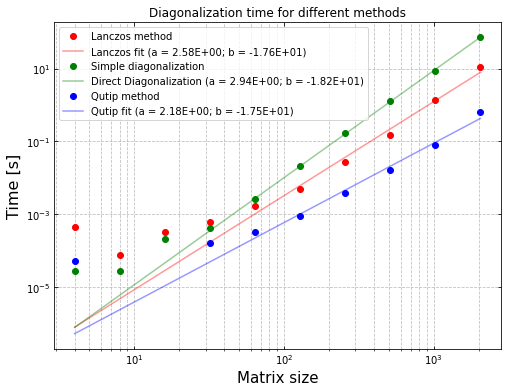

In [87]:
#plotting stuff

nn_list     = range(2,len(df_cpuTime)+2)
matrix_size = [2**i for i in range(2,max_nn)]

plt.figure(figsize=(8,6))

plt.plot(df_cpuTime.matrix_size, df_cpuTime.Lanczos_time,linestyle="None",marker='o',label="Lanczos method",color="red")
plt.plot(df_cpuTime.matrix_size,predict_lanc,color='red',linestyle='-', alpha = 0.4, label = 'Lanczos fit (a = '+"{:.2E}".format(popt_lanc[0])+'; b = '+ "{:.2E}".format(popt_lanc[1])+')')


plt.plot(df_cpuTime.matrix_size, df_cpuTime.Simple_diag_time,linestyle="None",marker='o',label="Simple diagonalization",color='green')
plt.plot(df_cpuTime.matrix_size, predict_diag,color='green',linestyle='-', alpha = 0.4, label = 'Direct Diagonalization (a = '+"{:.2E}".format(popt_diag[0])+'; b = '+ "{:.2E}".format(popt_diag[1])+')')


plt.plot(df_cpuTime.matrix_size, df_cpuTime.Qutip_time,linestyle="None",marker='o',label="Qutip method",color='blue')
plt.plot(df_cpuTime.matrix_size, predict_qutip,color='blue',linestyle='-', alpha = 0.4, label = 'Qutip fit (a = '+"{:.2E}".format(popt_qutip[0])+'; b = '+ "{:.2E}".format(popt_qutip[1])+')')

plt.legend(loc="best")
plt.xlabel("Matrix size",size=15)
plt.ylabel('Time [s]',size=16)
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.xscale('log')
plt.yscale('log')
plt.title("Diagonalization time for different methods")
plt.savefig('time_comparison.png')
plt.show()

In [32]:
df_E0_compare = pd.DataFrame({"nn": nn_list,
                              "e0_diag": E0_diag,
                              "e0_lanczos": E0_lanczos,
                              "e0_qutip": E0_diag_qutip}) 
df_E0_compare

,nn,e0_diag,e0_lanczos,e0_qutip
0,2,-0.750000,-0.750000,-0.750000
1,3,-0.416667,-0.416667,-0.416667
2,4,-0.500000,-0.500000,-0.500000
3,5,-0.473607,-0.473607,-0.473607
4,6,-0.519672,-0.519672,-0.519672
5,7,-0.479311,-0.479311,-0.479311
6,8,-0.516052,-0.516052,-0.516052
7,9,-0.492905,-0.492905,-0.492905
8,10,-0.509221,-0.509221,-0.509221
9,11,-0.499274,-0.499274,-0.499274


# Understanding the effects of "m" in Lanczos algorithm

In [33]:
#set nn = 8, however this can be changed. This is to get a relatively fast algorithm
nn = 8

In [34]:
H = np.array(Heisenberg_hamiltonian(dim, nn, h_field))    
# v0 has to be given as input which belong to subspace (Complex^n)
v0   = np.random.rand( dim**nn ) + np.random.rand( dim**nn )*1j 
v0 /= np.sqrt( np.dot( v0, v0 ) )

m_list = range(1,(2**nn)+1)
E0_mlist = []

for m in m_list:
    
    E= lanczos_full(H,v0,m)
    E0_mlist.append(E[0]/nn)

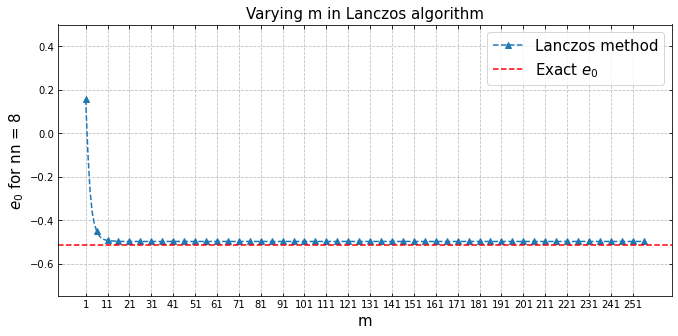

In [35]:
exact_E0 = E0_diag[int(nn-2)]

plt.figure(figsize=(11,5))
plt.plot(m_list,E0_mlist,ls="--",marker="^",markevery=5,label="Lanczos method")
plt.axhline(exact_E0,ls='--',c="red",label="Exact $e_0$")
plt.xticks(range(1,len(m_list),10))

plt.ylim([-0.75, 0.5])
plt.title("Varying m in Lanczos algorithm",size=15)
plt.xlabel("m",size=15)
plt.ylabel("$e_0$ for nn = "+str(nn),size=15)
plt.legend(loc="best",prop={'size': 15})
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')

plt.show()

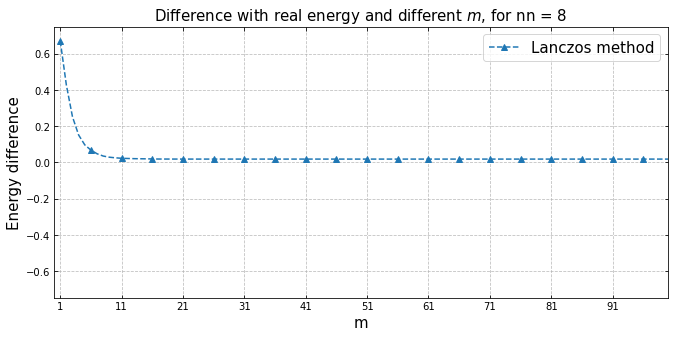

In [36]:
exact_E0 = E0_diag[int(nn-2)]

plt.figure(figsize=(11,5))
plt.plot(m_list,E0_mlist - exact_E0,ls="--",marker="^",markevery=5,label="Lanczos method")
plt.xticks(range(1,len(m_list),10))

plt.title("Difference with real energy and different $m$, for nn = "+str(nn),size=15)
plt.xlabel("m",size=15)
plt.ylabel("Energy difference",size=15)
plt.legend(loc="best",prop={'size': 15})
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.ylim([-0.75, 0.75])
plt.xlim([0,100])
plt.show()

## Scatterplot of the eigenvalues obtained for the two methods

If eigenvalues are the same, we expect them to be on a line of slope 1.0. 

In [37]:
from sklearn.linear_model import LinearRegression
x = []
y = []
for i in range(len(E0_lanczos)):
    x.append(E0_lanczos[i])
    y.append(E0_diag[i])

model = np.polyfit(x, y, 1)
predict = np.poly1d(model)

from sklearn.metrics import r2_score
print("R score=", r2_score(y, predict(x)))

R score= 1.0


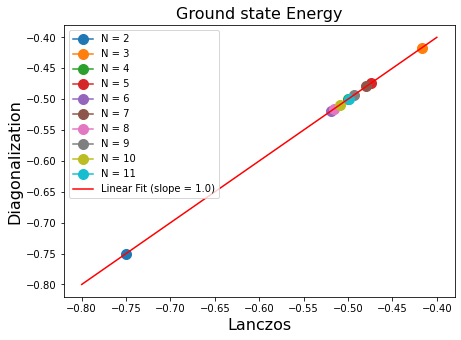

In [38]:
x_lin_reg = np.arange(-0.8, -0.3, 0.1)
y_lin_reg = predict(x_lin_reg)

import seaborn as sns; 
#sns.set_theme(color_codes=True)

plt.figure(figsize=(7, 5))
for i in range(len(E0_lanczos)):
    plt.plot(E0_lanczos[i], E0_diag[i], marker="o",  markersize=10,label="N = "+str(i+2))
plt.plot(x_lin_reg, y_lin_reg, c = 'r', label = 'Linear Fit (slope = '+str(round(model[0], 2))+')')
plt.legend()
plt.xlabel("Lanczos",size=16)
plt.ylabel("Diagonalization",size=16)
plt.title("Ground state Energy",size=16)
plt.show()

# What is the time complexity of different algorithms for different type of matrices?
- Sparse matrices (should return best performances)
- Random matrices

In [25]:
#setting parameters
dim      = 2
h_field  = 1.
max_nn   = 13
max_iter = 50

In [26]:
def get_non_zero_elems(matrix):
    '''
    Given a matrix as input, this function returns the average number of elements that are non zero along a rows
    '''
    #nonzero_sparse = len(H_sparse[H_sparse != 0])
    df    = pd.DataFrame(matrix)
    n_row = len(df)
    cols = df.columns
    df['== zero'] = df[cols].eq(0).sum(axis=1)
    nonzero_sparse = np.mean(n_row - df['== zero'])
    return nonzero_sparse

Do the job

In [27]:
max_nn = 13

In [30]:
time_random   = []
time_sparse   = []

time_diag     = []
time_diag_sp  = []

time_qutip    = []
time_qutip_sp = []

d_random = []
d_sparse = []

for nn in range(2,max_nn):
    print("Iteration:", nn - 1, "/", max_nn - 2)
    
    #sparse matrix
    H = Heisenberg_hamiltonian_pbc(dim, nn, h_field)  
    H_sparse = np.array(H)    
    d_sparse.append(get_non_zero_elems(H_sparse))
    
    # Lanczos diagonalization step
    # v0 has to be given as input which belong to subspace (Complex^n)
    v0   = np.random.rand( dim**nn ) + np.random.rand( dim**nn )*1j 
    v0  /= np.sqrt( np.dot( v0, v0 ) )
    m   = v0.shape[0] # value 7 in case of nn=3
    
    time_sparse.append( get_lanczos_iteration_time(H_sparse, nn, v0, m) )
    time_diag_sp.append(get_diagonalization_iteration_time(H_sparse, nn))
    time_qutip_sp.append(get_qutip_iteration_time(H_sparse, nn))
    
    H_random = np.random.rand(dim**nn,dim**nn)
    #nozero_random = len(H_random[H_random != 0])
    d_random.append(get_non_zero_elems(H_random))
    
    time_random.append(get_lanczos_iteration_time(H_random, nn, v0, m))
    time_diag.append(get_diagonalization_iteration_time(H_random, nn))
    time_qutip.append(get_qutip_iteration_time(H_random, nn))
    

Iteration: 1 / 11
Iteration: 2 / 11
Iteration: 3 / 11
Iteration: 4 / 11
Iteration: 5 / 11
Iteration: 6 / 11
Iteration: 7 / 11
Iteration: 8 / 11
Iteration: 9 / 11
Iteration: 10 / 11
Iteration: 11 / 11


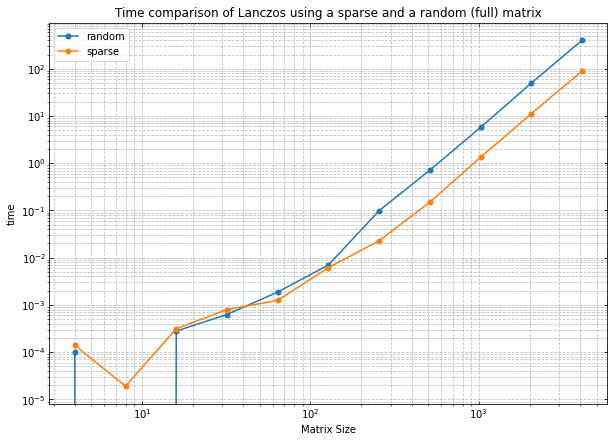

In [31]:
plt.figure(figsize=(10, 7))
matrix_size = [2**i for i in range(2, max_nn)]
x = matrix_size.copy()

plt.plot(matrix_size, time_random, '.-',  markersize=10, label = 'random')
plt.plot(matrix_size, time_sparse,'.-', markersize=10,  label = 'sparse')
plt.title('Time comparison of Lanczos using a sparse and a random (full) matrix')
plt.xlabel('Matrix Size')
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('time')
plt.legend()
plt.show()

In [32]:
times_df = pd.DataFrame({'matrix_size' : matrix_size,
                         'sparse_times': time_sparse,
                         'random_times': time_random,
                         'sparse_diag_times': time_diag_sp,
                         'diag_times': time_diag ,
                         'sparse_qutip_times': time_qutip_sp,
                         'qutip_times': time_qutip,
                         })
times_df.to_csv('size_vs_times.csv', index = False)
times_df

,matrix_size,sparse_times,random_times,sparse_diag_times,diag_times,sparse_qutip_times,qutip_times
0,4,0.000139,0.000100,0.000027,0.000040,0.000051,0.000070
1,8,0.000019,0.000000,0.000000,0.000000,0.000000,0.000179
2,16,0.000313,0.000280,0.000000,0.000080,0.000168,0.000081
3,32,0.000797,0.000626,0.000374,0.000417,0.000000,0.000312
4,64,0.001250,0.001875,0.002245,0.002084,0.000313,0.001730
5,128,0.006149,0.006996,0.020415,0.011493,0.000937,0.009039
6,256,0.022852,0.099127,0.186988,0.107667,0.003750,0.050522
7,512,0.150301,0.711940,1.264079,0.668686,0.016040,0.271933
8,1024,1.335464,5.741823,8.636860,4.243824,0.083521,0.954162
9,2048,11.207180,49.803507,71.340828,32.645644,0.591646,6.263945


In [84]:
times_df = pd.read_csv('size_vs_times.csv')
times_df

,matrix_size,sparse_times,random_times,sparse_diag_times,diag_times,sparse_qutip_times,qutip_times
0,4,0.000139,0.000100,0.000027,0.000040,0.000051,0.000070
1,8,0.000019,0.000000,0.000000,0.000000,0.000000,0.000179
2,16,0.000313,0.000280,0.000000,0.000080,0.000168,0.000081
3,32,0.000797,0.000626,0.000374,0.000417,0.000000,0.000312
4,64,0.001250,0.001875,0.002245,0.002084,0.000313,0.001730
5,128,0.006149,0.006996,0.020415,0.011493,0.000937,0.009039
6,256,0.022852,0.099127,0.186988,0.107667,0.003750,0.050522
7,512,0.150301,0.711940,1.264079,0.668686,0.016040,0.271933
8,1024,1.335464,5.741823,8.636860,4.243824,0.083521,0.954162
9,2048,11.207180,49.803507,71.340828,32.645644,0.591646,6.263945


In [90]:
time_restricted = times_df[times_df.matrix_size > 32]
log_x = np.log(time_restricted.matrix_size)
log_times_sparse   = np.log(time_restricted.sparse_times)
log_times_random   = np.log(time_restricted.random_times)
log_times_diag_sp  = np.log(time_restricted.sparse_diag_times)
log_times_diag     = np.log(time_restricted.diag_times)
log_times_qutip_sp = np.log(time_restricted.sparse_qutip_times)
log_times_qutip    = np.log(time_restricted.qutip_times)

In [91]:
#do the fitting for the different cases
from scipy.optimize import curve_fit

popt_sparse, _   = curve_fit(linear, log_x , log_times_sparse)
popt_random, _   = curve_fit(linear, log_x , log_times_random)
popt_diag, _     = curve_fit(linear, log_x , log_times_diag)
popt_diag_sp, _  = curve_fit(linear, log_x , log_times_diag_sp)
popt_qutip, _    = curve_fit(linear, log_x , log_times_qutip)
popt_qutip_sp, _ = curve_fit(linear, log_x , log_times_qutip_sp)

predict_sparse   = [ np.exp(popt_sparse[0]*np.log(size) + popt_sparse[1]) for size in times_df.matrix_size]
predict_random   = [ np.exp(popt_random[0]*np.log(size) + popt_random[1]) for size in times_df.matrix_size]
predict_diag     = [ np.exp(popt_diag[0]*np.log(size) + popt_diag[1]) for size in times_df.matrix_size]
predict_diag_sp  = [ np.exp(popt_diag_sp[0]*np.log(size) + popt_diag_sp[1]) for size in times_df.matrix_size]
predict_qutip    = [ np.exp(popt_qutip[0]*np.log(size) + popt_qutip[1]) for size in times_df.matrix_size]
predict_qutip_sp = [ np.exp(popt_qutip_sp[0]*np.log(size) + popt_qutip_sp[1]) for size in times_df.matrix_size]

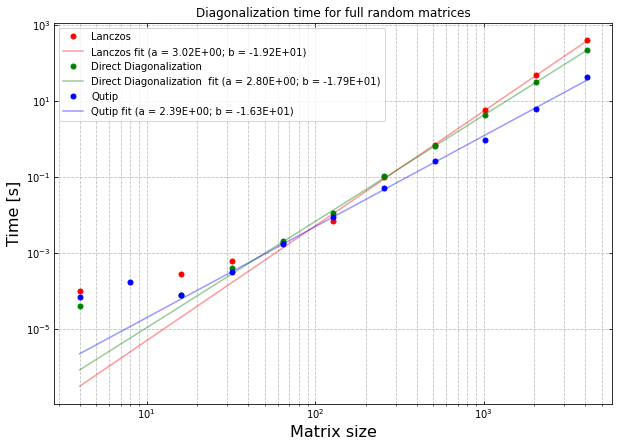

In [95]:
# random matrix plots
plt.figure(figsize=(10, 7))
#plt.title('Curve fitting',size=16)

plt.plot(times_df.matrix_size, times_df.random_times,color='red',marker=".", linestyle="None",markersize=10,  label = 'Lanczos')
plt.plot(times_df.matrix_size,predict_random,color='red', alpha = 0.4, label = 'Lanczos fit (a = '+"{:.2E}".format(popt_random[0])+'; b = '+ "{:.2E}".format(popt_random[1])+')')

plt.plot(times_df.matrix_size, times_df.diag_times,color='green',marker=".", linestyle="None",markersize=10,  label = 'Direct Diagonalization' )
plt.plot(times_df.matrix_size, predict_diag,color='green',  alpha = 0.4, label = 'Direct Diagonalization  fit (a = '+"{:.2E}".format(popt_diag[0])+'; b = '+ "{:.2E}".format(popt_diag[1])+')')

plt.plot(times_df.matrix_size, times_df.qutip_times,color='blue',marker=".",linestyle="None", markersize=10,  label = 'Qutip' )
plt.plot(times_df.matrix_size, predict_qutip,color='blue', alpha = 0.4, label = 'Qutip fit (a = '+"{:.2E}".format(popt_qutip[0])+'; b = '+ "{:.2E}".format(popt_qutip[1])+')')

plt.ylabel('Time [s]',size=16)
plt.xlabel('Matrix size',size=16)
plt.xscale('log')
plt.yscale('log')
plt.title("Diagonalization time for full random matrices")
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.savefig('time_comparison_random_matrix+fitting.png')
plt.legend()

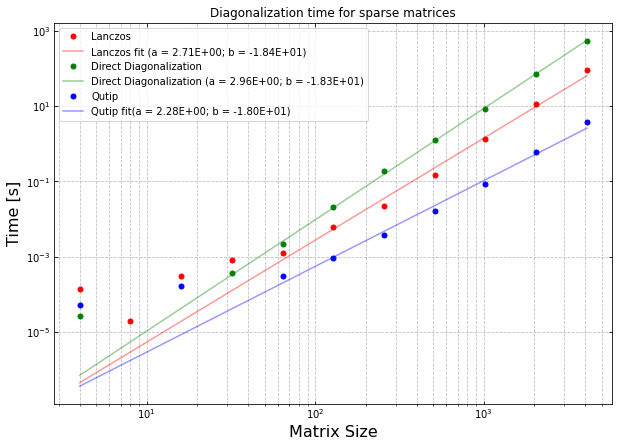

In [96]:
# sparse matrix plots
plt.figure(figsize=(10, 7))
#plt.title('Curve fitting - Sparse matrices')
#plt.suptitle('Time performances for different algorithms')

plt.plot(times_df.matrix_size, times_df.sparse_times,".",c='red', markersize=10,  label = 'Lanczos')
plt.plot(times_df.matrix_size, predict_sparse, c='red', alpha = 0.4, label = 'Lanczos fit (a = '+"{:.2E}".format(popt_sparse[0])+'; b = '+ "{:.2E}".format(popt_sparse[1])+')')

plt.plot(times_df.matrix_size, times_df.sparse_diag_times,".",c='green', markersize=10,  label = 'Direct Diagonalization' )
plt.plot(times_df.matrix_size, predict_diag_sp, c='green', alpha = 0.4,label = 'Direct Diagonalization (a = '+"{:.2E}".format(popt_diag_sp[0])+'; b = '+ "{:.2E}".format(popt_diag_sp[1])+')')

plt.plot(times_df.matrix_size, times_df.sparse_qutip_times,".",c='blue', markersize=10,  label = 'Qutip' )
plt.plot(times_df.matrix_size, predict_qutip_sp, c='blue', alpha = 0.4,label = 'Qutip fit(a = '+"{:.2E}".format(popt_qutip_sp[0])+'; b = '+ "{:.2E}".format(popt_qutip_sp[1])+')')
plt.ylabel('Time [s]',size=16)
plt.xlabel('Matrix Size',size=16)
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.title("Diagonalization time for sparse matrices")
plt.savefig('time_comparison_sparse_matrix+fitting.png')
plt.xscale('log')
plt.yscale('log')
plt.legend()

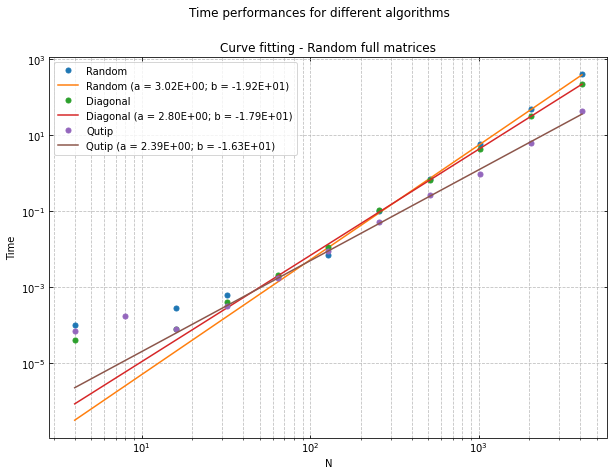

In [38]:
#random matrix plots
plt.figure(figsize=(10, 7))
plt.title('Curve fitting - Random full matrices')
plt.suptitle('Time performances for different algorithms')

plt.plot(times_df.matrix_size, times_df.random_times,".", markersize=10,  label = 'Random')
plt.plot(times_df.matrix_size,predict_random, label = 'Random (a = '+"{:.2E}".format(popt_random[0])+'; b = '+ "{:.2E}".format(popt_random[1])+')')

plt.plot(times_df.matrix_size, times_df.diag_times,".", markersize=10,  label = 'Diagonal' )
plt.plot(times_df.matrix_size, predict_diag, label = 'Diagonal (a = '+"{:.2E}".format(popt_diag[0])+'; b = '+ "{:.2E}".format(popt_diag[1])+')')

plt.plot(times_df.matrix_size, times_df.qutip_times,".", markersize=10,  label = 'Qutip' )
plt.plot(times_df.matrix_size, predict_qutip, label = 'Qutip (a = '+"{:.2E}".format(popt_qutip[0])+'; b = '+ "{:.2E}".format(popt_qutip[1])+')')
plt.ylabel('Time')
plt.xlabel('N')
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.xscale('log')
plt.yscale('log')
plt.legend()

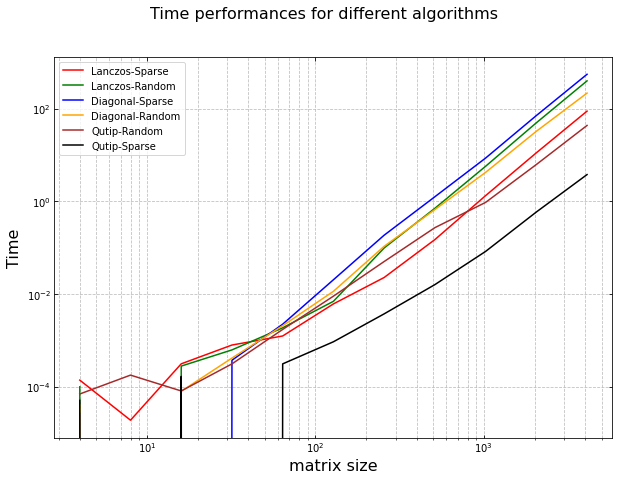

In [39]:
plt.figure(figsize=(10, 7))
plt.suptitle('Time performances for different algorithms',size=16)
plt.plot(times_df.matrix_size, time_sparse, markersize=10, c="red", label = 'Lanczos-Sparse')
plt.plot(times_df.matrix_size, time_random, markersize=10, c='green', label = 'Lanczos-Random')
plt.plot(times_df.matrix_size, time_diag_sp, markersize=10, c='blue', label = 'Diagonal-Sparse' )
plt.plot(times_df.matrix_size, time_diag, markersize=10, c='orange', label = 'Diagonal-Random')
plt.plot(times_df.matrix_size, time_qutip, markersize=10, c='brown', label = 'Qutip-Random')
plt.plot(times_df.matrix_size, time_qutip_sp, markersize=10, c='black', label = 'Qutip-Sparse' )
plt.ylabel('Time',size=16)
plt.xlabel('matrix size',size=16)
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.xscale('log')
plt.yscale('log')
plt.legend()

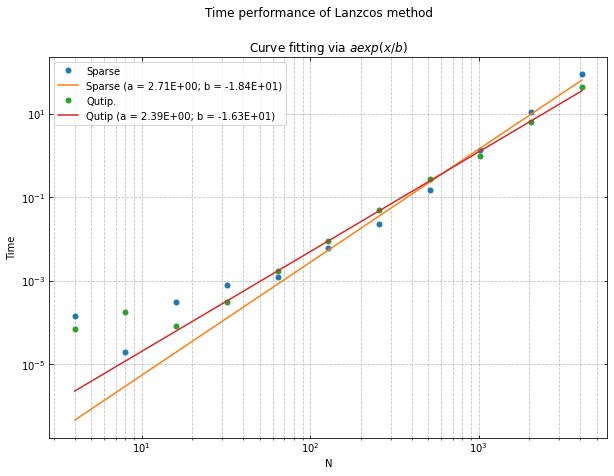

In [41]:
plt.figure(figsize=(10, 7))
plt.title('Curve fitting via $a exp(x/b)$')
plt.suptitle('Time performance of Lanzcos method')
plt.plot(times_df.matrix_size, time_sparse,".", markersize=10,  label = 'Sparse')
plt.plot(times_df.matrix_size, predict_sparse,  label = 'Sparse (a = '+"{:.2E}".format(popt_sparse[0])+'; b = '+ "{:.2E}".format(popt_sparse[1])+')')
plt.plot(times_df.matrix_size, time_qutip,".", markersize=10,  label = 'Qutip.' )
plt.plot(times_df.matrix_size, predict_qutip, label = 'Qutip (a = '+"{:.2E}".format(popt_qutip[0])+'; b = '+ "{:.2E}".format(popt_qutip[1])+')')
plt.ylabel('Time')
plt.xlabel('N')
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [42]:
#get correlation
def get_r(xdata, ydata, popt):
    residuals = ydata - np.exp(linear(np.log(xdata), *popt))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [43]:
r2_sparse = get_r(time_restricted.matrix_size, time_restricted.sparse_times, popt_sparse)
r2_sparse

0.9104527797295843

In [44]:
r2_random = get_r(time_restricted.matrix_size, time_restricted.random_times, popt_random)
r2_random

0.9986774557727864

In [45]:
r2_diag = get_r(time_restricted.matrix_size, time_restricted.diag_times, popt_diag)
r2_diag

0.9999284263299366

In [46]:
r2_diag_sp = get_r(time_restricted.matrix_size, time_restricted.sparse_diag_times, popt_diag_sp)
r2_diag_sp

0.9995980543034162

In [47]:
r2_qutip = get_r(time_restricted.matrix_size, time_restricted.qutip_times, popt_qutip)
r2_qutip

0.9594606303061727

In [48]:
r2_qutip_sp = get_r(time_restricted.matrix_size, time_restricted.sparse_qutip_times, popt_qutip_sp)
r2_qutip_sp

0.8814481107094475

Apparently the complexity goes exponentially with N (being the number of particles). Nevertheless it can be seen that the Lanczos for sparse matrices (such as the Hamiltonian that we have) is much better than the traditional diagonalization, but this is not true when having a dense matrix.

# Varying h field in h ={[0,3]}

In [55]:
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import sys

In [50]:
def get_ground_state_energy(hamiltonian, nn):
    ground_state = hamiltonian.eigenenergies()[0]/nn
    return ground_state

In [51]:
h_steps = np.arange(0, 3.05, 0.05)
nn      = np.arange(2, 12)
dim     = 2

In [52]:
Energies = np.zeros((len(nn),len(h_steps)))

for ii, n_part in enumerate(nn):
    print("N_particles", n_part)
    for jj, h_field in enumerate(h_steps):
        H_pbc = Heisenberg_hamiltonian_pbc(dim, n_part, h_field)
        Energies[ii, jj] = get_ground_state_energy(H_pbc, n_part)

N_particles 2
N_particles 3
N_particles 4
N_particles 5
N_particles 6
N_particles 7
N_particles 8
N_particles 9
N_particles 10
N_particles 11


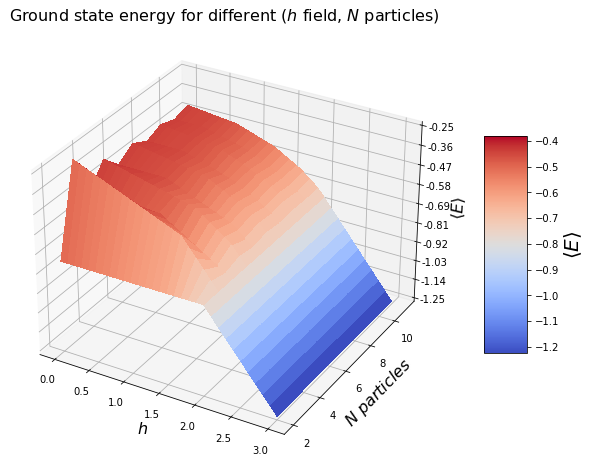

In [64]:
# Prepare for plots
fig = plt.figure(figsize = (15,8))
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(h_steps, nn)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$h$',size=16)
ax.set_ylabel(r'$N\ particles$',size=16)
ax.set_zlabel(r'$\langle E \rangle$',size=16)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5).set_label(label = r'$\langle E \rangle$',size=20,weight='bold')
plt.title("Ground state energy for different ($h$ field, $N$ particles)",size=16)
plt.savefig('GS-3d.png')
plt.show()

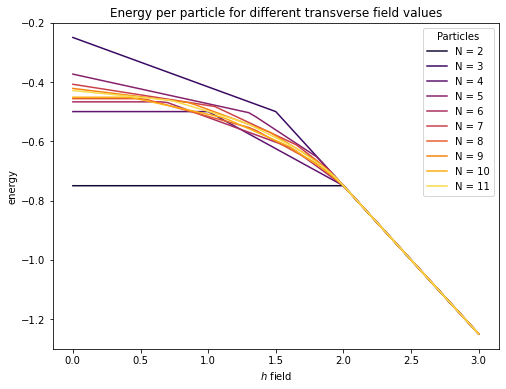

In [56]:
sns.set_palette('inferno', len(nn))

plt.figure(figsize = (8,6))
for ii, n_part in enumerate(nn):
    plt.plot(np.array(h_steps), Energies[ii,:], label = "N = " + str(n_part))
    
plt.legend(title = "Particles")
plt.xlabel("$h$ field")
plt.ylabel("energy")
plt.title("Energy per particle for different transverse field values")
plt.savefig('gs_vs_hfield.png')
plt.show()

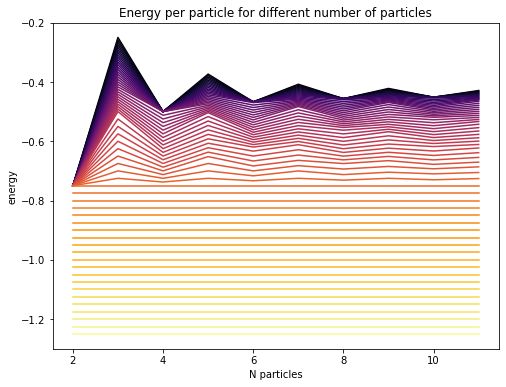

In [57]:
import seaborn as sns

sns.set_palette('inferno', len(h_steps))

plt.figure(figsize = (8,6))
for ii, h_field in enumerate(h_steps):
    plt.plot(np.array(nn), Energies[:,ii])

plt.xlabel("N particles")
plt.ylabel("energy")
plt.title("Energy per particle for different number of particles")
plt.savefig('gs_vs_nn.png')
plt.show()